# Clustering: MSE no Rel 100 

In [1]:
import joblib
import os
import time

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

from astroExplain.spectra import clustering
from sdss.metadata import MetaData

meta = MetaData()

In [2]:
n_spec_bin_03 = 181_850
n_top_1_percent = int(n_spec_bin_03 * 0.01)
n_top_5_percent = int(n_spec_bin_03 * 0.05)
n_top_1_percent, n_top_5_percent

(1818, 9092)

# Custom functions

## Data ingestion

In [3]:
def data_ingestion(
    metric, n_segments,
    run_id, bin_id,
    explanations_dir, spectra_dir
):
    """
    Function to load the data for a given metric and run_id.
    """

    data_dict = {
        "metric": metric,
        "run_id": run_id,
        "weights": None,
        "norm_weights": None,
        "unique_weights": None,
        "norm_unique_weights": None,
        "anomalies": None,
        "anomalies_df": None,
    }

    data_dict["weights"] = np.load(
        f"{explanations_dir}/{bin_id}/"
        f"{data_dict['metric']}/"
        f"weights_{data_dict['run_id']}.npy"
    )

    data_dict["norm_weights"] = clustering.normalize_weights_l2_abs(
        data_dict["weights"]
    )

    data_dict["unique_weights"] = clustering.compress_weights_per_segments(
        weights=data_dict["weights"],
        n_segments=n_segments,
    )
    data_dict["norm_unique_weights"] = clustering.normalize_weights_l2_abs(
        data_dict["unique_weights"]
    )

    data_dict["anomalies"] = np.load(
        f"{spectra_dir}/{bin_id}/"
        f"{data_dict['metric']}/top_anomalies.npy",
        mmap_mode="r"
    )

    data_dict["anomalies_df"] = pd.read_csv(
        f"{spectra_dir}/{bin_id}/"
        f"{data_dict['metric']}/top_anomalies.csv.gz",
        index_col="specobjid",
    )

    return data_dict

## averages in clusters

In [4]:
def plot_averages_clusters(
    spectra_cluster_dict,
    weights_cluster_dict,
    wave,
):

    n_clusters = len(spectra_cluster_dict)

    fig, axs = plt.subplots(
        nrows=n_clusters,
        ncols=2,
        figsize=None,
        sharex=True,
        sharey=False,
        tight_layout=True,
    )

    # set minor ticks on
    for ax in axs.flatten(): ax.minorticks_on()

    #  weights of centroid

    for label, cluster_weights in weights_cluster_dict.items():

        avg_weights = cluster_weights.mean(axis=0)
        avg_weights /= np.max(avg_weights)

        avg_spectrum = spectra_cluster_dict[label].mean(axis=0)

        axs[label, 0].plot(
            wave, avg_spectrum,
            color="black",
        )
        # weights
        axs[label, 1].plot(
            wave, avg_weights,
            color="black",
            label=f"Cluster {label}"
        )

        axs[label, 1].legend(
            [f"Cluster {label}"],
            fontsize=6,
            handlelength=0, handletextpad=0,
            loc="upper right",
            frameon=False
        )
        # set limits
        axs[label, 1].set_ylim(0, 1.1)

    axs[n_clusters - 1,0].set_xlabel("$\lambda$ [$\AA$]")
    axs[n_clusters - 1,1].set_xlabel("$\lambda$ [$\AA$]")

    return fig, axs

<>:51: SyntaxWarning: invalid escape sequence '\l'
<>:52: SyntaxWarning: invalid escape sequence '\l'
<>:51: SyntaxWarning: invalid escape sequence '\l'
<>:52: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_81087/3553967644.py:51: SyntaxWarning: invalid escape sequence '\l'
  axs[n_clusters - 1,0].set_xlabel("$\lambda$ [$\AA$]")
/tmp/ipykernel_81087/3553967644.py:52: SyntaxWarning: invalid escape sequence '\l'
  axs[n_clusters - 1,1].set_xlabel("$\lambda$ [$\AA$]")


## Centroids

In [5]:
def plot_centroids(
    spectra_cluster_dict,
    centroids,
    wave,
    n_segments,
):

    n_clusters = len(spectra_cluster_dict)

    fig, axs = plt.subplots(
        nrows=n_clusters,
        ncols=2,
        figsize=None,
        sharex=True,
        sharey=False,
        tight_layout=True,
    )

    # set minor ticks on
    for ax in axs.flatten(): ax.minorticks_on()

    #  weights of centroid

    for label, centroid in enumerate(centroids):

        centroid = clustering.expand_weights_per_segments(
            centroid.reshape(1, -1),
            wave.size,
            n_segments,
        )

        centroid /= np.max(centroid)
        centroid = centroid.reshape(-1)
        avg_spectrum = spectra_cluster_dict[label].mean(axis=0)

        axs[label, 0].plot(
            wave, avg_spectrum,
            color="black",
        )
        # weights
        axs[label, 1].plot(
            wave, centroid,
            color="black",
            label=f"Cluster {label}"
        )

        axs[label, 1].legend(
            [f"Cluster {label}"],
            fontsize=6,
            handlelength=0, handletextpad=0,
            loc="upper right",
            frameon=False
        )
        # set limits
        axs[label, 1].set_ylim(0, 1.1)

    axs[n_clusters - 1,0].set_xlabel("$\lambda$ [$\AA$]")
    axs[n_clusters - 1,1].set_xlabel("$\lambda$ [$\AA$]")

    return fig, axs

<>:57: SyntaxWarning: invalid escape sequence '\l'
<>:58: SyntaxWarning: invalid escape sequence '\l'
<>:57: SyntaxWarning: invalid escape sequence '\l'
<>:58: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_81087/3820476029.py:57: SyntaxWarning: invalid escape sequence '\l'
  axs[n_clusters - 1,0].set_xlabel("$\lambda$ [$\AA$]")
/tmp/ipykernel_81087/3820476029.py:58: SyntaxWarning: invalid escape sequence '\l'
  axs[n_clusters - 1,1].set_xlabel("$\lambda$ [$\AA$]")


In [6]:
def plot_single_centroid(
    centroid, avg_spectrum,
    wave,
    n_segments=128,
):

    centroid = clustering.expand_weights_per_segments(
        centroid.reshape(1, -1),
        wave.size,
        n_segments,
    )

    centroid /= np.max(centroid)
    centroid = centroid.reshape(-1)

    fig, axs = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=None,
        sharex=True,
        sharey=False,
        tight_layout=True,
    )

    # set minor ticks on
    for ax in axs.flatten(): ax.minorticks_on()

    axs[0].plot(
        wave, avg_spectrum,
        color="black",
    )
    # weights
    axs[1].plot(
        wave, centroid,
        color="black",
    )

    # set limits
    axs[1].set_ylim(0, 1.1)
    axs[1].set_xlabel("$\lambda$ [$\AA$]")
    axs[0].set_ylabel("Normalized flux")
    axs[1].set_ylabel("Normalized weights (MAX)")

    return fig, axs

<>:40: SyntaxWarning: invalid escape sequence '\l'
<>:40: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_81087/3278944214.py:40: SyntaxWarning: invalid escape sequence '\l'
  axs[1].set_xlabel("$\lambda$ [$\AA$]")


# Directories

In [7]:
bin_id = "bin_03"
phd_dir = "/home/elom/phd"
spectra_dir = f"{phd_dir}/00_phd_code/spectra"
explanations_dir = f"{phd_dir}/00_phd_code/explanations"
paper_figures_dir = f"{phd_dir}/00_paper_explain-me-why/sections/figures/"
clusterin_dir = f"{phd_dir}/00_phd_code/clustering"
wave = np.load(f"{spectra_dir}/wave_spectra_imputed.npy")


# Data ingestion

In [8]:
score_dict = data_ingestion(
    metric="mse_noRel100",
    n_segments=150,
    run_id="20250514144513_uniform_150_scale_0.9",
    bin_id=bin_id,
    explanations_dir=explanations_dir,
    spectra_dir=spectra_dir
)
score_dict.keys()


Base size: 25, Residual size: 23
New number of segments: 151


dict_keys(['metric', 'run_id', 'weights', 'norm_weights', 'unique_weights', 'norm_unique_weights', 'anomalies', 'anomalies_df'])

# Top 1%
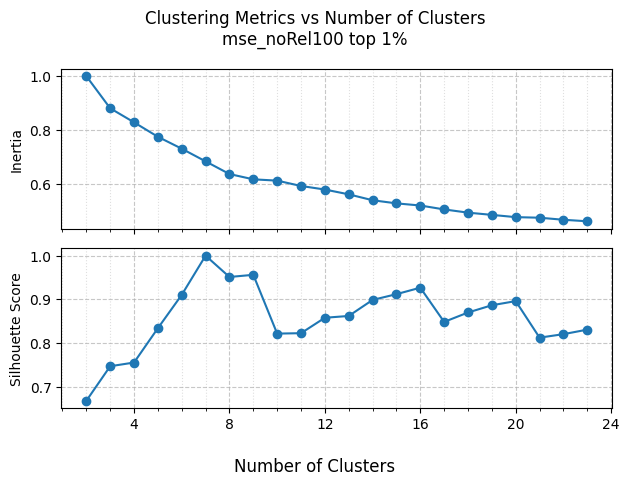


## Train model

In [ ]:
# n_clusters = 7

# start_time = time.perf_counter()

# kmeans = KMeans(
#     n_clusters=n_clusters, random_state=0
# ).fit(score_dict["norm_unique_weights"][-1*n_top_1_percent:])

# end_time = time.perf_counter()
# print(f"train time: {end_time - start_time:.2f} seconds")

# # save the model
# kmeans_model_id = (
#     f"kmeans_top_1_percent_{n_clusters}_clusters_"
#     f"{score_dict['run_id']}"
# )

# kmeans_model_dir = (
#     f"{clusterin_dir}/{bin_id}/"
#     f"{score_dict['metric']}/"
#     f"{kmeans_model_id}"
# )

# if not os.path.exists(kmeans_model_dir):
#     os.makedirs(kmeans_model_dir)

# # save the model

# joblib.dump(
#     kmeans,
#     f"{kmeans_model_dir}/"
#     f"{kmeans_model_id}.joblib"
# )

# cluster_labels = kmeans.labels_

# # get spectra and weights per cluster
# (
#     spectra_cluster_dict, weights_cluster_dict
# ) = clustering.group_spectra_by_cluster(
#     cluster_labels=cluster_labels,
#     anomalies_array=score_dict["anomalies"][-1*n_top_1_percent:],
#     weights=score_dict["norm_weights"][-1*n_top_1_percent:],
#     print_n_clusters=True
# )

# score_dict["spectra_cluster_dict_top_1_percent"] = spectra_cluster_dict
# score_dict["weights_cluster_dict_top_1_percent"] = weights_cluster_dict

# (
#     _, unique_weights_cluster_dict
# ) = clustering.group_spectra_by_cluster(
#     cluster_labels=cluster_labels,
#     anomalies_array=score_dict["anomalies"][-1*n_top_1_percent:],
#     weights=score_dict["norm_unique_weights"][-1*n_top_1_percent:],
#     print_n_clusters=False
# )

# score_dict["unique_weights_cluster_dict_top_1_percent"] = (
#     unique_weights_cluster_dict
# )
# # plot averages

# centroids = kmeans.cluster_centers_

# score_dict["centroids_top_1_percent"] = centroids
# # train time: 0.03 seconds
# # 0;245
# # 1;617
# # 2;287
# # 3;340
# # 4;55
# # 5;196
# # 6;78

train time: 0.03 seconds
0;245
1;617
2;287
3;340
4;55
5;196
6;78


## Load model

In [11]:
n_clusters = 7
kmeans_model_id = (
    f"kmeans_top_1_percent_{n_clusters}_clusters_"
    f"{score_dict['run_id']}"
)

kmeans_model_dir = (
    f"{clusterin_dir}/{bin_id}/"
    f"{score_dict['metric']}/"
    f"{kmeans_model_id}"
)

kmeans = joblib.load(
    f"{kmeans_model_dir}/"
    f"{kmeans_model_id}.joblib"

)

cluster_labels = kmeans.labels_

# get spectra and weights per cluster
(
    spectra_cluster_dict, weights_cluster_dict
) = clustering.group_spectra_by_cluster(
    cluster_labels=cluster_labels,
    anomalies_array=score_dict["anomalies"][-1*n_top_1_percent:],
    weights=score_dict["norm_weights"][-1*n_top_1_percent:],
    print_n_clusters=True
)

score_dict["spectra_cluster_dict_top_1_percent"] = spectra_cluster_dict
score_dict["weights_cluster_dict_top_1_percent"] = weights_cluster_dict

(
    _, unique_weights_cluster_dict
) = clustering.group_spectra_by_cluster(
    cluster_labels=cluster_labels,
    anomalies_array=score_dict["anomalies"][-1*n_top_1_percent:],
    weights=score_dict["norm_unique_weights"][-1*n_top_1_percent:],
    print_n_clusters=False
)

score_dict["unique_weights_cluster_dict_top_1_percent"] = (
    unique_weights_cluster_dict
)

score_dict["centroids_top_1_percent"] = kmeans.cluster_centers_


0;245
1;617
2;287
3;340
4;55
5;196
6;78


## Save metadata

In [35]:
top_1_percent_df = score_dict['anomalies_df'].iloc[-1*n_top_1_percent:].copy()
top_1_percent_df["cluster"] = kmeans.labels_
top_1_percent_df.to_csv(
    f"{kmeans_model_dir}/"
    f"top_1_percent_anomalies.csv.gz",
    compression="gzip",
)

## Centroids

Base size: 25, Residual size: 23
New number of segments: 151
Base size: 25, Residual size: 23
New number of segments: 151
Base size: 25, Residual size: 23
New number of segments: 151
Base size: 25, Residual size: 23
New number of segments: 151
Base size: 25, Residual size: 23
New number of segments: 151
Base size: 25, Residual size: 23
New number of segments: 151
Base size: 25, Residual size: 23
New number of segments: 151


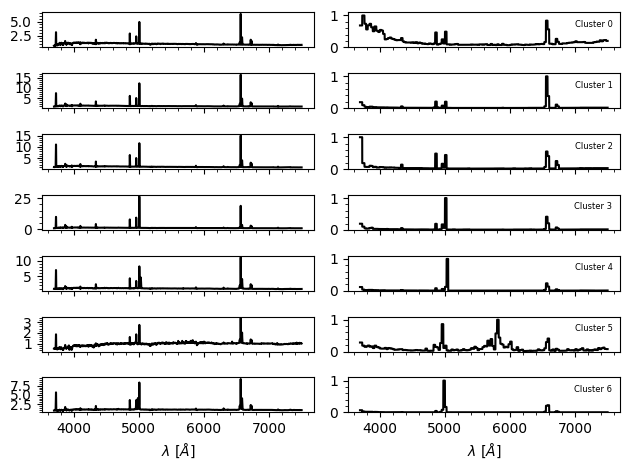

In [16]:
fig, axs = plot_centroids(
    spectra_cluster_dict=score_dict["spectra_cluster_dict_top_1_percent"],
    centroids=score_dict["centroids_top_1_percent"],
    wave=wave,
    n_segments=150,
)
fig.savefig(
    f"{kmeans_model_dir}/top_1_percent_avg_spec_centroids.pdf",
)
fig.savefig(
    f"{kmeans_model_dir}/top_1_percent_avg_spec_centroids.jpeg",
)

In [24]:
n_segments = 150

for label, centroid in enumerate(score_dict["centroids_top_1_percent"]):

    fig, axs = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=None,
        sharex=True,
        sharey=False,
        tight_layout=True,
    )

    # set minor ticks on
    for ax in axs.flatten(): ax.minorticks_on()

    centroid = clustering.expand_weights_per_segments(
        centroid.reshape(1, -1),
        wave.size,
        n_segments,
    )

    centroid /= np.max(centroid)
    centroid = centroid.reshape(-1)
    avg_spectrum = spectra_cluster_dict[label].mean(axis=0)

    axs[0].plot(
        wave, avg_spectrum,
        color="black",
    )
    # weights
    axs[1].plot(
        wave, centroid,
        color="black",
        label=f"Cluster {label}"
    )

    axs[0].legend(
        [f"Average spectrum - Cluster {label}"],
        fontsize=6,
        handlelength=0, handletextpad=0,
        loc="upper right",
        frameon=False
    )
    # set limits
    axs[1].set_ylim(0, 1.1)
    axs[1].set_xlabel("$\lambda$ [$\AA$]")

    fig.suptitle(
        "Average spectrum - Explanation centroid\n"
        f"Top 1% anomalies\n"
        f"Cluster {label}"
        # fontsize=8,
    )

    fig.savefig(
        f"{kmeans_model_dir}/top_1_percent_avg_spec_centroid_{label}.pdf",
    )
    fig.savefig(
        f"{kmeans_model_dir}/top_1_percent_avg_spec_centroid_{label}.jpeg",
    )
    plt.clf()
    plt.close(fig)



<>:47: SyntaxWarning: invalid escape sequence '\l'
<>:47: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_81087/1196720738.py:47: SyntaxWarning: invalid escape sequence '\l'
  axs[1].set_xlabel("$\lambda$ [$\AA$]")


Base size: 25, Residual size: 23
New number of segments: 151
Base size: 25, Residual size: 23
New number of segments: 151
Base size: 25, Residual size: 23
New number of segments: 151
Base size: 25, Residual size: 23
New number of segments: 151
Base size: 25, Residual size: 23
New number of segments: 151
Base size: 25, Residual size: 23
New number of segments: 151
Base size: 25, Residual size: 23
New number of segments: 151


## Individual spectra

,mjd,plate,fiberid,run2d,ra,dec,z,zErr,zWarning,class,...,zWarning_noqso,targetType,programname,instrument,snMedian,ABSSB,BROAD,ebv,score,cluster
specobjid,,,,,,,,,,,,,,,,,,,,,
1939939074022336512,53905,1723,49,26,233.77385,8.010576,0.118616,0.000019,0,GALAXY,...,0,SCIENCE,legacy,SDSS,22.52934,AGN,BROADLINE,0.040510,4.773745,6
309735756123891712,51910,275,412,26,161.11264,0.896529,0.075562,0.000005,0,GALAXY,...,0,SCIENCE,legacy,SDSS,20.24640,STARBURST,STARBURST,0.038393,4.774176,1
611501946842408960,52017,543,503,26,118.56148,37.845768,0.019557,0.000007,0,GALAXY,...,0,SCIENCE,legacy,SDSS,26.86421,STARBURST,STARBURST,0.043752,4.774475,1
407606036384475136,51999,362,110,26,265.58461,54.056685,0.089788,0.000018,0,GALAXY,...,0,SCIENCE,legacy,SDSS,18.84275,STARFORMING,STARFORMING,0.035735,4.775666,5
566361496662075392,51999,503,123,26,155.02005,1.267037,0.033561,0.000005,0,GALAXY,...,0,SCIENCE,legacy,SDSS,26.69458,STARBURST,STARBURST,0.034236,4.775805,2


# Top 5%
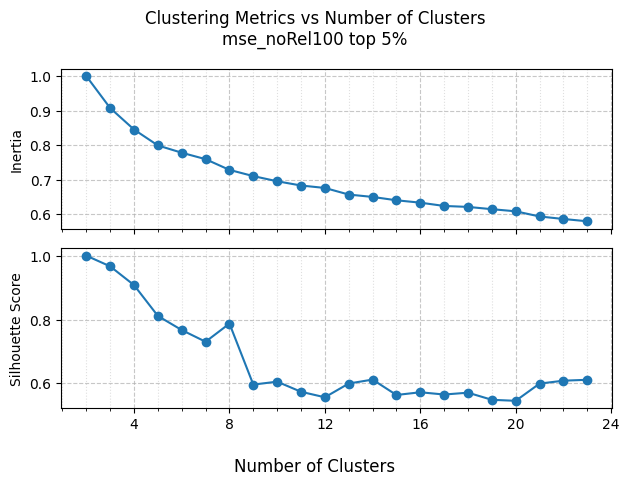

In [ ]:
n_clusters = 8

start_time = time.perf_counter()

kmeans = KMeans(
    n_clusters=n_clusters, random_state=0
).fit(score_dict["norm_unique_weights"][-1*n_top_5_percent:])

end_time = time.perf_counter()
print(f"train time: {end_time - start_time:.2f} seconds")

# save the model
kmeans_model_id = (
    f"kmeans_top_5_percent_{n_clusters}_clusters_"
    f"{score_dict['run_id']}"
)

kmeans_model_dir = (
    f"{clusterin_dir}/{bin_id}/"
    f"{score_dict['metric']}/"
    f"{kmeans_model_id}"
)

if not os.path.exists(kmeans_model_dir):
    os.makedirs(kmeans_model_dir)

# save the model

joblib.dump(
    kmeans,
    f"{kmeans_model_dir}/"
    f"{kmeans_model_id}.joblib"
)

cluster_labels = kmeans.labels_

# get spectra and weights per cluster
(
    spectra_cluster_dict, weights_cluster_dict
) = clustering.group_spectra_by_cluster(
    cluster_labels=cluster_labels,
    anomalies_array=score_dict["anomalies"][-1*n_top_5_percent:],
    weights=score_dict["norm_weights"][-1*n_top_5_percent:],
    print_n_clusters=True
)

score_dict["spectra_cluster_dict_top_5_percent"] = spectra_cluster_dict
score_dict["weights_cluster_dict_top_5_percent"] = weights_cluster_dict

(
    _, unique_weights_cluster_dict
) = clustering.group_spectra_by_cluster(
    cluster_labels=cluster_labels,
    anomalies_array=score_dict["anomalies"][-1*n_top_5_percent:],
    weights=score_dict["norm_unique_weights"][-1*n_top_5_percent:],
    print_n_clusters=False
)

score_dict["unique_weights_cluster_dict_top_5_percent"] = (
    unique_weights_cluster_dict
)

centroids = kmeans.cluster_centers_

score_dict["centroids_top_5_percent"] = centroids

train time: 0.28 seconds
0;978
1;649
2;920
3;945
4;1003
5;477
6;1898
7;2222


# Average spectrun and explantions

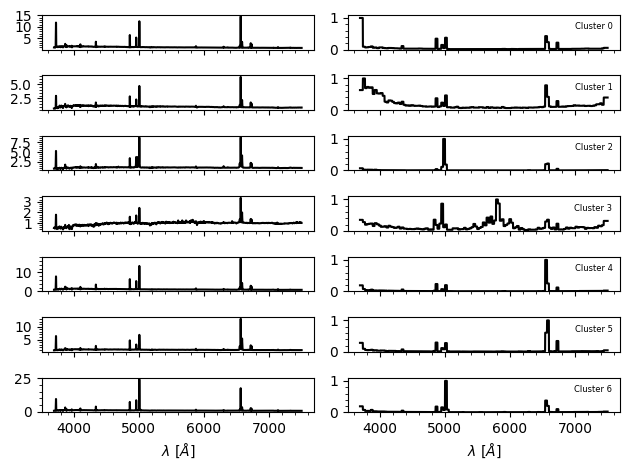

In [12]:
fig, axs = plot_averages_clusters(
    spectra_cluster_dict=spectra_cluster_dict,
    weights_cluster_dict=weights_cluster_dict,
    wave=wave,
)


# Centroids

Base size: 29, Residual size: 61
New number of segments: 129
Base size: 29, Residual size: 61
New number of segments: 129
Base size: 29, Residual size: 61
New number of segments: 129
Base size: 29, Residual size: 61
New number of segments: 129
Base size: 29, Residual size: 61
New number of segments: 129
Base size: 29, Residual size: 61
New number of segments: 129
Base size: 29, Residual size: 61
New number of segments: 129


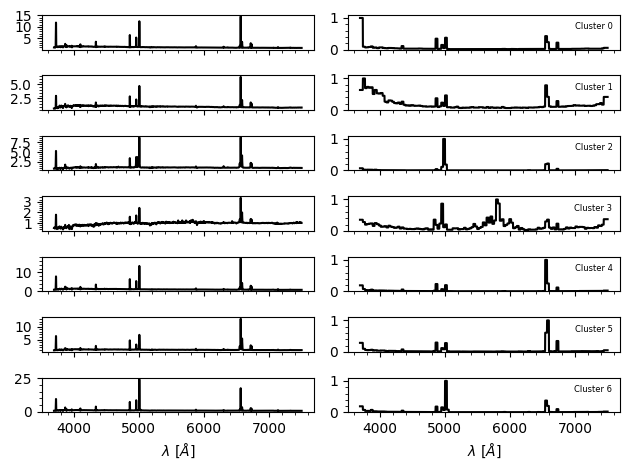

In [13]:
centroids = kmeans.cluster_centers_
fig, axs = plot_centroids(
    spectra_cluster_dict=spectra_cluster_dict,
    centroids=centroids,
    wave=wave,
    n_segments=128,
)

## Single centroids

Base size: 29, Residual size: 61
New number of segments: 129


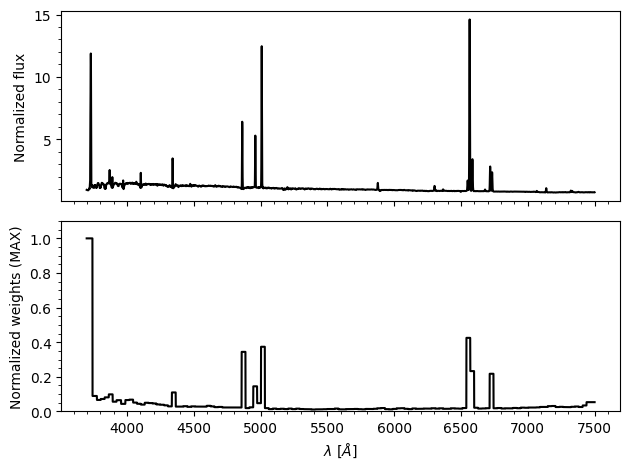

In [14]:
cluster_label = 0
fig, axs = plot_single_centroid(
    centroid=centroids[cluster_label],
    avg_spectrum=spectra_cluster_dict[cluster_label].mean(axis=0),
    wave=wave,
    n_segments=128,
)

Base size: 29, Residual size: 61
New number of segments: 129


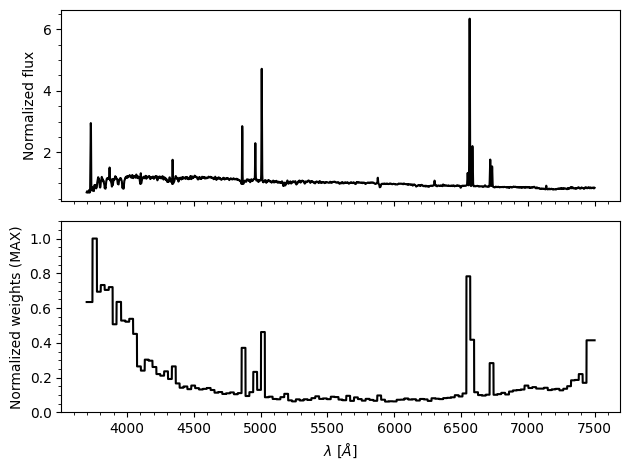

In [15]:
cluster_label = 1
fig, axs = plot_single_centroid(
    centroid=centroids[cluster_label],
    avg_spectrum=spectra_cluster_dict[cluster_label].mean(axis=0),
    wave=wave,
    n_segments=128,
)

Base size: 29, Residual size: 61
New number of segments: 129


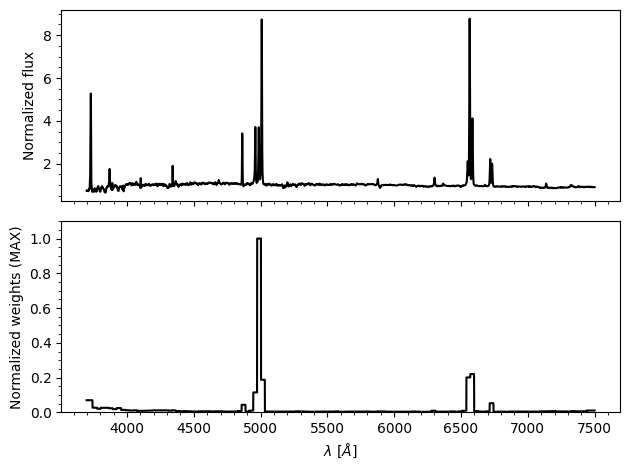

In [16]:
cluster_label = 2
fig, axs = plot_single_centroid(
    centroid=centroids[cluster_label],
    avg_spectrum=spectra_cluster_dict[cluster_label].mean(axis=0),
    wave=wave,
    n_segments=128,
)

Base size: 29, Residual size: 61
New number of segments: 129


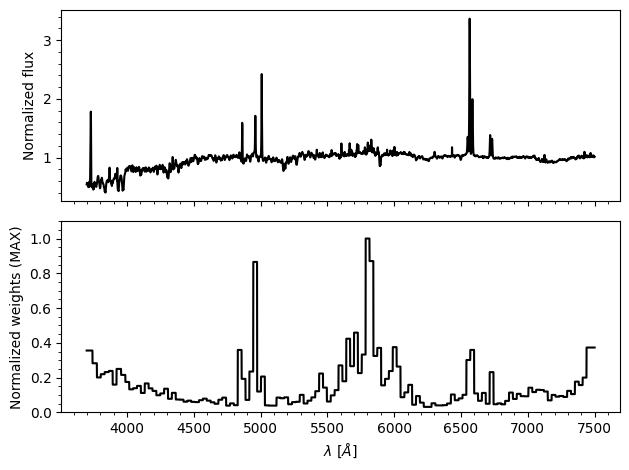

In [17]:
cluster_label = 3
fig, axs = plot_single_centroid(
    centroid=centroids[cluster_label],
    avg_spectrum=spectra_cluster_dict[cluster_label].mean(axis=0),
    wave=wave,
    n_segments=128,
)

Base size: 29, Residual size: 61
New number of segments: 129


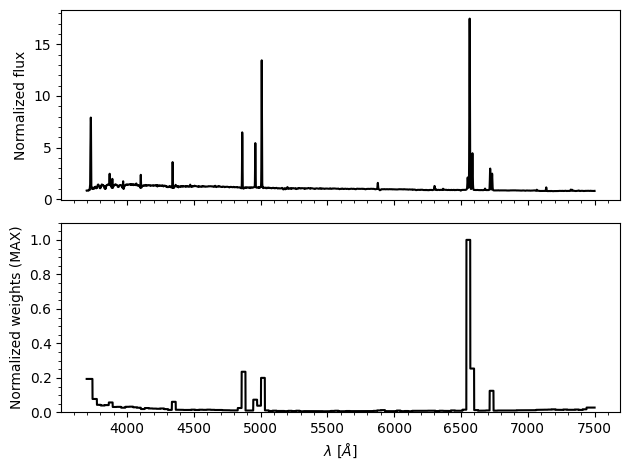

In [18]:
cluster_label = 4
fig, axs = plot_single_centroid(
    centroid=centroids[cluster_label],
    avg_spectrum=spectra_cluster_dict[cluster_label].mean(axis=0),
    wave=wave,
    n_segments=128,
)

Base size: 29, Residual size: 61
New number of segments: 129


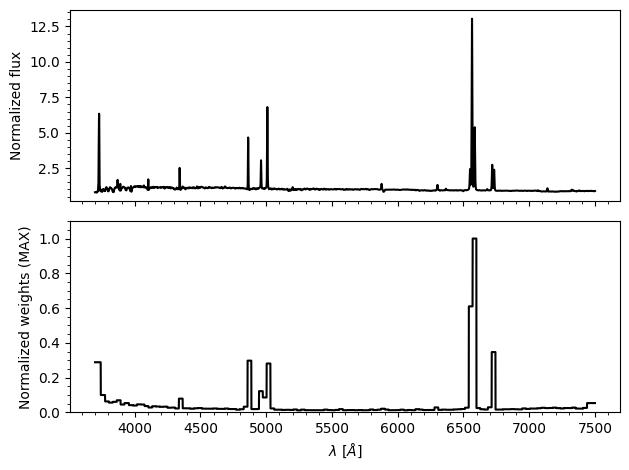

In [19]:
cluster_label = 5
fig, axs = plot_single_centroid(
    centroid=centroids[cluster_label],
    avg_spectrum=spectra_cluster_dict[cluster_label].mean(axis=0),
    wave=wave,
    n_segments=128,
)

Base size: 29, Residual size: 61
New number of segments: 129


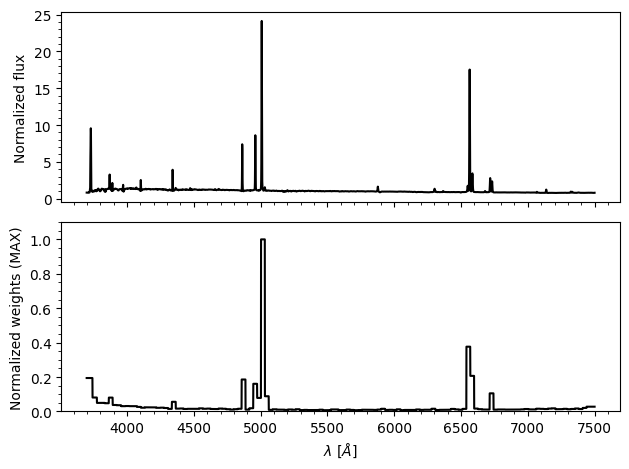

In [20]:
cluster_label = 6
fig, axs = plot_single_centroid(
    centroid=centroids[cluster_label],
    avg_spectrum=spectra_cluster_dict[cluster_label].mean(axis=0),
    wave=wave,
    n_segments=128,
)

# MSE filter 250 kms noRel97

## Data ingestion

In [49]:
mse_filter_250kms_noRel97_dict = data_ingestion(
    metric="mse_filter_250kms_noRel97",
    run_id="20250427105355_uniform_5000_scale",
    bin_id=bin_id,
    explanations_dir=explanations_dir,
    spectra_dir=spectra_dir
)

Base size: 29, Residual size: 61
New number of segments: 129


## Clustering
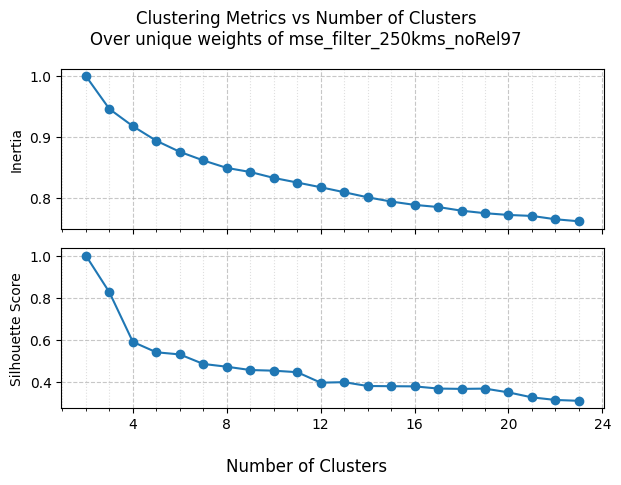

In [50]:
n_clusters = 6

start_time = time.perf_counter()

kmeans = KMeans(
    n_clusters=n_clusters, random_state=0
).fit(mse_filter_250kms_noRel97_dict["norm_unique_weights"])

end_time = time.perf_counter()
print(f"train time: {end_time - start_time:.2f} seconds")

cluster_labels = kmeans.labels_

# get spectra and weights per cluster
(
    spectra_cluster_dict, weights_cluster_dict
) = clustering.group_spectra_by_cluster(
    cluster_labels=cluster_labels,
    anomalies_array=mse_filter_250kms_noRel97_dict["anomalies"],
    weights=mse_filter_250kms_noRel97_dict["norm_weights"],
    print_n_clusters=True
)

(
    _, unique_weights_cluster_dict
) = clustering.group_spectra_by_cluster(
    cluster_labels=cluster_labels,
    anomalies_array=mse_filter_250kms_noRel97_dict["anomalies"],
    weights=mse_filter_250kms_noRel97_dict["norm_unique_weights"],
    print_n_clusters=False
)

centroids = kmeans.cluster_centers_


train time: 0.19 seconds
Cluster: 0,N. spectra: 1765
Cluster: 1,N. spectra: 782
Cluster: 2,N. spectra: 2925
Cluster: 3,N. spectra: 2395
Cluster: 4,N. spectra: 901
Cluster: 5,N. spectra: 1232


# MSE filter 250 kms noRel100

# MSE filter 250 kms noRel97